In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature

Imported `literature` (904B0F94) at Monday, 03. Aug 2020 01:39

In [4]:
has_abstract = ~literature['abstract'].isnull()

**TODO: use title if not abstract, add keywords, use full text if available**

In [5]:
literature['abstract_clean'] = literature['abstract_clean'].fillna('')

In [6]:
domain_features = literature.index.to_frame().copy()

# Domain knowledge / semantic features

Spacy corpus and models are trained on generic web-based texts, not on scientific or biomedical research. In order to make use of named entities it is worth including a minimum of domain-specific terminology:

- [ ] chromosomes
  - [ ] locus
- [ ] mutations
  - [ ] in proteins
  - [ ] in genes
- [ ] gene & protein names
  - [x] Ensebml identifiers regular expression
  - [ ] refseq regular expression
  - Note: Entrez ids are just numbers - would require a lot of manual
  - [ ] MANE
  - [ ] gene names
  - [ ] protein names
- [ ] metabolite names
  - [ ] HMDB - would bias for human research
- [x] diseases
  - [ ] OMIM
  - [x] ClinVar
  - [ ] an ontology?
- [ ] drug names
  - [ ] DrugBank
- [x] species
  - [x] NCBI

In [7]:
from pandas import read_table

In [8]:
from helpers.text_processing import (
    check_usage,
    highlight_first,
    matches_n_consecutive_words
)

In [9]:
from functools import partial

check_usage_in_abstracts = partial(check_usage, data=literature, column='abstract_clean')

In [10]:
from tqdm import tqdm
tqdm.pandas()

/home/krassowski/.pyenv/versions/3.8.3/envs/multi-omics/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Gene

### Ensembl

> ENS(species)(object type)(identifier).(version)

In [11]:
from pandas import read_html

In [12]:
ens_object_types, ens_species_prefixes = read_html('data/ensembl_prefixes.html')
ens_object_types.columns = ['code', 'object_type']

In [13]:
ens_object_types 

code             object_type
0    E                    exon
1   FM  Ensembl protein family
2    G                    gene
3   GT               gene tree
4    P                 protein
5    R      regulatory feature
6    T              transcript

In [14]:
ens_species_prefixes

Prefix                                        Species name
0             ENSCPO                        Cavia porcellus (Guinea Pig)
1             ENSZAL     Zonotrichia albicollis (White-throated sparrow)
2             ENSMUN                Melopsittacus undulatus (Budgerigar)
3             ENSRRO  Rhinopithecus roxellana (Golden snub-nosed monkey)
4             ENSCGR        Cricetulus griseus (Chinese hamster CHOK1GS)
..               ...                                                 ...
279           ENSHHU                                Hucho hucho (Huchen)
280  MGP_129S1SvImJ_                    Mus musculus (Mouse 129S1/SvImJ)
281           ENSSPU                       Sphenodon punctatus (Tuatara)
282           ENSBTA                                    Bos taurus (Cow)
283           ENSPCA                           Procavia capensis (Hyrax)

[284 rows x 2 columns]

In [15]:
from re import escape

In [16]:
ens_prefix_re = '|'.join(ens_species_prefixes.Prefix.apply(escape))
ens_object_types_re = '|'.join(ens_object_types .code.apply(escape))
ensembl_expression = rf'(?P<species_preifx>{ens_prefix_re})(?P<object_type>{ens_object_types_re})(?P<identifier>\d+)(?P<version_suffix>\.\d+)?'

In [17]:
from re import match

In [18]:
match(ensembl_expression, 'ENSG00000010404').groupdict()

{'species_preifx': 'ENS',
 'object_type': 'G',
 'identifier': '00000010404',
 'version_suffix': None}

In [19]:
has_ensembl_id = literature['abstract_clean'].str.contains(ensembl_expression) != False

/home/krassowski/.pyenv/versions/3.8.3/envs/multi-omics/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [20]:
sum(has_ensembl_id)

2

In [21]:
literature[has_ensembl_id][['title', 'abstract_clean']]

title  \
uid                                                                                                             
28243742  Integrative multi-omics analysis revealed SNP-lncRNA-mRNA (SLM) networks in human peripheral blo...   
32163894  Inferences of Individual Drug Response-Related Long Non-coding RNAs Based on Integrating Multi-o...   

                                                                                               abstract_clean  
uid                                                                                                            
28243742  Long non-coding RNAs (lncRNAs) serve as important controller of cellular functions via regulatin...  
32163894  Differences in individual drug responses are obstacles in breast cancer (BRCA) treatment, so pre...

Not worth further consideration (at least on abstract levels).

## Diseases

In [22]:
disease_names_df = read_table('data/disease_names')
disease_names_df

#DiseaseName                SourceName  \
0                      1-2 finger syndactyly  Human Phenotype Ontology   
1      1-2 toe complete cutaneous syndactyly  Human Phenotype Ontology   
2                         1-2 toe syndactyly  Human Phenotype Ontology   
3                      1-3 finger syndactyly  Human Phenotype Ontology   
4                         1-3 toe syndactyly  Human Phenotype Ontology   
...                                      ...                       ...   
43749                     Zygodactyly type 3                     MONDO   
43750                     Zygodactyly type 4                     MONDO   
43751                            Zygomycosis                       NaN   
43752         ​Keratosis pilaris atrophicans                     MONDO   
43753         ​Keratosis pilaris atrophicans                  Orphanet   

      ConceptID       SourceID  DiseaseMIM LastModified            Category  
0      C4023732     HP:0010704         NaN  16 Feb 2016             Finding  
1      C4025140     HP:0005767         NaN  16 Feb 2016             Finding  
2      C4023726     HP:0010711         NaN  16 Feb 2016             Finding  
3      C4023730     HP:0010706         NaN  16 Feb 2016             Finding  
4      C4025774     HP:0001459         NaN  16 Feb 2016             Finding  
...         ...            ...         ...          ...                 ...  
43749  CN203276  MONDO:0017544         NaN  17 Apr 2020             Disease  
43750  CN203277  MONDO:0017545         NaN  17 Apr 2020             Disease  
43751  C0043541            NaN         NaN  16 Feb 2016  Infectious disease  
43752  C4310982  MONDO:0018855         NaN  28 Apr 2020             Disease  
43753  C4310982       ORPHA498         NaN  28 Apr 2020             Disease  

[43754 rows x 7 columns]

In [23]:
disease_names_df.Category.value_counts()

Disease                     26046
Finding                     15029
Named protein variant        1117
Infectious disease            951
Pharmacological response      547
Blood group                    63
phenotype instruction           1
Name: Category, dtype: int64

In [24]:
disease_names = disease_names_df[disease_names_df.Category == 'Disease']['#DiseaseName'].str.lower()
len(disease_names.unique())

25922

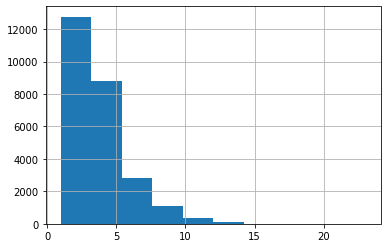

In [25]:
disease_words_count = disease_names.str.split(' ').apply(len)
disease_words_count.hist();

In [26]:
disease_words_count.quantile(0.999)

13.0

In [27]:
ignored_disease_terms = {
    'rare',
    'c',
    'acquired',
    'localized'
}

In [28]:
mentioned_diseases = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=set(disease_names) - ignored_disease_terms,
    consecutive_n=int(disease_words_count.quantile(0.999))
)

100%|██████████| 3456/3456 [00:05<00:00, 635.44it/s]


In [29]:
domain_features['mentioned_diseases'] = mentioned_diseases
domain_features['mentioned_diseases_set'] = mentioned_diseases.apply(set)
domain_features['mentions_n_diseases'] = mentioned_diseases.apply(len)

In [30]:
detected_disease_occurrences = Series(domain_features['mentioned_diseases_set'].apply(list).sum())
detected_disease_occurrences.value_counts().head(50)

cancer                                   786
disease                                  722
carcinoma                                132
inflammation                              77
cardiovascular                            68
diabetes                                  60
colorectal cancer                         59
adenocarcinoma                            53
hepatocellular carcinoma                  47
glioblastoma                              42
lung cancer                               41
aging                                     37
injury                                    34
obesity                                   33
squamous cell carcinoma                   31
ovarian cancer                            28
lung adenocarcinoma                       27
melanoma                                  26
gbm                                       24
inflammatory bowel disease                21
fatty liver disease                       20
kidney disease                            19
diabetes m

In [31]:
clinical_findings = disease_names_df[disease_names_df.Category == 'Finding']['#DiseaseName'].str.lower()
len(clinical_findings.unique())

15014

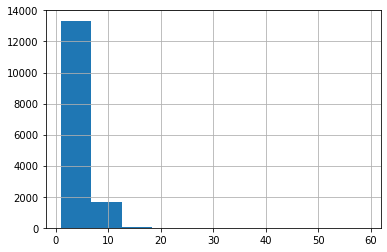

In [32]:
clinical_findings_words_count = clinical_findings.str.split(' ').apply(len)
clinical_findings_words_count.hist();

In [33]:
ignored_findings_terms = {
    'none',
    'add',
    '5)',
    'id',
    'delay',
    'diagnostic',
    'healthy',
    'affected',
    'array',
    'falls',
    'obligate',
    # quantifiers
    'all',
    'mild',
    'frequent',
    'progressive',
    'frequency',
    'mitochondrial',
    'symptomatic'
}

In [34]:
mentioned_findings = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=set(clinical_findings) - ignored_findings_terms,
    consecutive_n=int(clinical_findings_words_count.quantile(0.999))
)

100%|██████████| 3456/3456 [00:11<00:00, 308.02it/s]


In [35]:
domain_features['mentioned_clinical_findings'] = mentioned_findings
domain_features['mentioned_clinical_findings_set'] = mentioned_findings.apply(set)
domain_features['mentions_n_clinical_findings'] = mentioned_findings.apply(len)
mentioned_findings_occurrences = Series(domain_features['mentioned_clinical_findings_set'].apply(list).sum())
mentioned_findings_occurrences.value_counts().head(50)

breast cancer                    118
asthma                            30
infections                        27
leukemia                          27
prostate cancer                   27
psychiatric                       19
plethora                          19
poor prognosis                    17
colitis                           17
dissection                        15
arthritis                         15
colon cancer                      15
hypoxia                           14
shock                             14
atherosclerosis                   13
bladder cancer                    13
asymptomatic                      12
triple-negative breast cancer     12
heart failure                     11
hepatitis                         11
autism spectrum                   11
autism                            11
streptococcus                     11
crohn's disease                   11
cholangiocarcinoma                 8
sepsis                             8
pain                               8
h

## Species

In [36]:
species = read_table('data/taxdump/names.dmp', usecols=[2, 4, 6])
species.columns = ['name', 'unique_name', 'type']
species

name  \
0                                                        root   
1                                                    Bacteria   
2                                                    bacteria   
3                                                  eubacteria   
4                                                      Monera   
...                                                       ...   
3234121                                     Lebrunia neglecta   
3234122  Lilyopsis medusa (Metschnikoff & Metschnikoff, 1871)   
3234123                                      Lilyopsis medusa   
3234124                                       Lilyopsis rosea   
3234125                                     Hydrothelphusinae   

                 unique_name                 type  
0                        NaN      scientific name  
1        Bacteria <bacteria>      scientific name  
2                        NaN           blast name  
3                        NaN  genbank common name  
4          Monera <bacteria>              in-part  
...                      ...                  ...  
3234121                  NaN              synonym  
3234122                  NaN            authority  
3234123                  NaN      scientific name  
3234124                  NaN              synonym  
3234125                  NaN      scientific name  

[3234126 rows x 3 columns]

In [37]:
species.type.sorted_value_counts()

index
scientific name        2260403
authority               503986
synonym                 169589
type material           149465
includes                 53463
equivalent name          49097
genbank common name      29623
common name              14493
acronym                   1197
genbank synonym           1110
in-part                    535
genbank acronym            483
anamorph                   284
blast name                 229
teleomorph                 169
Name: type, dtype: int64

In [38]:
head = species.head(100)
head.query('type == "type material"').tail(5)

name  \
89                                               ATCC 39565   
90  ATCC BAA-642 [[Shewanella affinis Ivanova et al. 2004]]   
91    CIP 107703 [[Shewanella affinis Ivanova et al. 2004]]   
92      KMM 3587 [[Shewanella affinis Ivanova et al. 2004]]   
97                                             strain LST-W   

                                                              unique_name  \
89                                               ATCC 39565 <type strain>   
90  ATCC BAA-642 [[Shewanella affinis Ivanova et al. 2004]] <type strain>   
91    CIP 107703 [[Shewanella affinis Ivanova et al. 2004]] <type strain>   
92      KMM 3587 [[Shewanella affinis Ivanova et al. 2004]] <type strain>   
97                                             strain LST-W <type strain>   

             type  
89  type material  
90  type material  
91  type material  
92  type material  
97  type material

In [39]:
species_names = set(
    species[(species.name != 'root') & ~species.type.isin({'authority', 'type material'})]
    .name
    .str.lower()
)
len(species_names)

2572241

In [40]:
species_type_materials = set(
    species[species.type.isin({'type material'})]
    .name
    # remove the citation from type material, take the name only
    .str.split(r' \[\[').str[0]
)
len(species_type_materials)

148755

In [41]:
assert 'human' in species_names
assert 'homo sapiens' in species_names

### Manual species curation

Note: type materials have to be case-sensitive:

In [42]:
species[species.name.str.lower() == 'and']

name          unique_name           type
1871628  AND  AND <type material>  type material

Cancer is a proper genus, but we do not want to match it as it would match cancer as a disease:

In [43]:
species[species.name.str.lower() == 'cancer']

name unique_name             type
31637  Cancer         NaN  scientific name

None of the articles appears to refer to a fish when they use "spot" either:

In [44]:
species[species.name.str.lower() == 'spot']

name unique_name         type
123457  spot         NaN  common name

In [45]:
check_usage_in_abstracts('spot')

uid
21831800    genomics level, exome sequencing has been the hot spot of the recent research. However, the pred...
25345010    riptomics and proteomics, is becoming the new hot spot of life science. Although the fast output...
31162831                                              Target spot is a newly emerging citrus disease caused by 
31616468    ean or median of the pixel intensities within the spot and then subjected to a within-slide norm...
Name: abstract_clean, dtype: object

Python is used as a programming language:

In [46]:
check_usage_in_abstracts('Python')

uid
23927696    available software.\n\n\nHere, we describe COBRA for Python (COBRApy), a Python package that pro...
25637560    _pipe). Omics Pipe is distributed as a standalone Python package for installation (https://pypi....
26072472    D IMPLEMENTATION\nMSProGene is written in Java and Python. It is open source and available at ht...
27986083    lated within a user-friendly implementation using Python and Docker. IMP is available at http://...
28640810    nted as a general-purpose toolbox using the PyGMO Python package to make the most of multicore c...
29746212    umber of examined species were identified using a Python script. Multiple genomic alignments of ...
30221093    lack of adequate data analysis training (e.g., R, Python) as a main challenge, in addition to no...
30596886    http://b2slab.upc.edu/software-and-tutorials/ and Python package: https://pypi.python.org/pypi/m...
30668675    //rgv.genouest.org. The website is implemented in Python, JavaScript and MongoDB, and is

California is used as place:

In [47]:
check_usage_in_abstracts('California')

uid
21194970    troprusside (SNP). QuantiGene (Panomics, Fremont, California) branched DNA (bDNA) assay was used...
28443069    . At "Long-term Soil Productivity Study" sites in California dominated by Ponderosa pine, we tes...
29339647    NN) held its 11th annual Congress in Los Angeles, California, between September 16 and 19, 2017....
29688803    dosis related omics evidence in the University of California Santa Cruz (UCSC) Genome Browser. F...
31299210    nd PCBs, in a women cohort with sera collected in California in the 1960s. Strikingly, this anal...
31825540    n," was held 20 to 23 June, 2019, in Los Angeles, California.\n\n\nThe CHPCA Meeting is an annua...
Name: abstract_clean, dtype: object

In [48]:
check_usage_in_abstracts('codon')

uid
16077939    Rat Sfrp1 (314 aa) consisted of a signal peptide (codon 1-31), Frizzled domain with ten conserve...
17611704    lineage specific T to G nucleotide change at stop codon of chimpanzee, rat, and mouse HES3 ortho...
26482106    ion to a changing environment: pathway structure, codon usage, metabolism. To measure adaptabili...
26850284    s data and subsets thereof to establish reference codon usage biases for codon optimization in s...
27633273    gnments, conservation and variation, CpG islands, codon context, usage bias and phylogenetic inf...
29222764    mplemented in MATLAB. METRADE uses microarray and codon usage data to model bacterial metabolic ...
30066640     collection of gene expression and sequence data, codon usage and protein abundances) to analyse...
31046701    p.Arg5688*), predicted to create a premature stop codon near the N-terminus of ADGRV1. Ophthalmo...
31071195    t Saccharomycopsis yeasts have reassigned the CTG codon and translate CTG into serine in

In [49]:
check_usage_in_abstracts('glycine')

uid
23883549    y butanol treatment. Notably, 3-phosphoglycerate, glycine, serine and urea related to general st...
27228119    esults suggested reprogrammed pathways related to glycine metabolism, fatty acids metabolism and...
27589727    in "phosphoglycerate mutase 2" and the metabolite glycine. We hypothesize that association studi...
27879288    RJ, CD44, and C4A, as well as increased levels of glycine and asparagine, and decreased levels o...
29325019    G sites, i.e. of glycerophospholipid PC(O-36: 5), glycine and a very low-density lipoprotein (VL...
29859941    fermentation pathways of the amino acids proline, glycine and leucine. But also a far-reaching r...
29930756    gnificantly altered glutamine, glucose and serine/glycine metabolism. The predominant upregulate...
30086113    tes (uridine, C-glycosyl tryptophan, and N-acetyl glycine) were statistically independent and th...
31029960    red metabolites, the metabolic pathway containing glycine, serine and threonine was the 

In [50]:
check_usage_in_abstracts('anemia')

uid
22960126    ta thalassemia (Het-βThal). Het-βThal causes mild anemia and is known to determine a pro-oxidant...
26948278    oorly understood. Moreover, current management of anemia in ESRD is controversial due to the "an...
27136057    at risk for a drug side effect (ribavirin-induced anemia) and how genetic variation (inosine tri...
29590102    cal phenotypes such as red blood cell parameters, anemia, and chronic kidney disease (CKD). In a...
Name: abstract_clean, dtype: object

In [51]:
check_usage_in_abstracts('hippocampus')

uid
16142419    placenta, and uterus. FGF22 mRNA was expressed in hippocampus and ovarian fibrotheoma. FGF7 prom...
27731396    files of PLF and PSF groups were acquired for the hippocampus and plasma to identify molecular p...
28300637    tabolite assignments from three ROIs (cerebellum, hippocampus and midbrain/hypothalamus) in posi...
30291623    filed the transcriptome and proteome of the mouse hippocampus during early stages of disease dev...
31942070                                                 The hippocampus is an important part of the limbic sys
32170004    essed in liver, brain cerebellum, frontal cortex, hippocampus and pituitary. Our studies provide...
32234596    significantly increased the levels of BDNF in the hippocampus. Cecum contents metabolomics revea...
Name: abstract_clean, dtype: object

Mixed usage: as referring to species or in another meaning:

In [52]:
check_usage_in_abstracts('indicator')

uid
26421150    with asthma. The outcome of interest was a binary indicator of asthma control defined by the use...
26444894     occurring within the warfighter as a preclinical indicator. Current methods for determining tox...
26870025    rRNA gene amplicon sequencing and methods such as indicator species analysis, the Kolmogorov-Smi...
28335448    . The multi-omics data, in combination with fecal indicator bacteria (FIB) counts, trace metal c...
29222764    sion, metabolism is increasingly being used as an indicator of the phenotypic outcome for drugs ...
29844878    non-coding RNA, which is known to be a prognostic indicator for breast cancer and stimulated by ...
30189879    e the ability to passively monitor behavior as an indicator of socialization and mood; accumulat...
31054440                  Ambient fine particle is a crucial indicator of air pollution brought into the air by
31258819    sing its human development index (HDI): a summary indicator of health, education, and in

But majority indicators would be false-positives, excluding; "fecal indicator bacteria" will match anyways on "bacteria".

Numeric only records are to vague and will be excluded to avoid false positives:

In [53]:
species[species.name == '382']

name          unique_name           type
905354  382  382 <type material>  type material

In [54]:
numeric_species_terms = {name for name in species.name if name.isnumeric()}
len(numeric_species_terms)

146

Some other species names excluded:

In [55]:
species[species.name.str.lower() == 'collection']

name unique_name             type
2217657  collection         NaN  scientific name

In [56]:
ignored_species_terms = {
    'cancer',
    'other',
    'collection',
    'synthetic',
    'artificial',
    'unknown',
    'none',
    'unidentified',
    'hybrid',
    'clinical samples',
    'vectors',
    'spot',
    'this',
    'data',
    'major',
    'colon',
    'cnv',  # copy number variation
    'goes',
    'automate',
    'axis',
    'idea',
    'laser',
    'beta',
    'areas',
    'electron',
    'bias',
    'python',
    'cis',  # chemistry prefix
    'insertion',
    'aa',   # amino acid
    'california',
    'codon',    # in sequence
    'glycine',  # amino acid
    'anemia',   # disease
    'hippocampus',
    'meta',
    'indicator'
}

Some names are just long:

In [57]:
x = Series(list(species_names))
x[x.str.len() > 100].head()

4788      cloning vector pb-degron-tvmvs-mcp-cnot7-e2a-mcp-cnot7-tevs-degron-p2a-ntevp-yap-t2a-14-3-3sigma...
20015     cloning vector pb-6-xnor-degron-tvmvs-mcp-tevs-cnot7-e2a-mcp-tvmvs-cnot7-tevs-degron-f2a-ntevp-f...
175405    cloning vector pb-5-xor-degron-tvmvs-mcp-cnot7-tevs-degron-e2a-mcp-tevs-tvmvs-cnot7-f2a-ntevp-fr...
202108    (megalobrama amblycephala x parabramis pekinensis) x (megalobrama amblycephala x parabramis peki...
256597    metschnikowia pimensis (s.o. suh, c.m. gibson & m. blackwell) c.p. kurtzman, c.j. robnett & e. b...
dtype: object

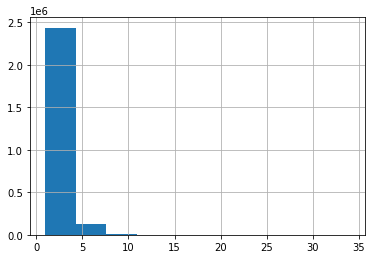

In [58]:
species_words_count_distribution = x.str.split(' ').apply(len)
species_words_count_distribution.hist();

For sanity, will only check for species names up to 8 words long (which captures 99.9% of the terms):

In [59]:
species_words_count_distribution.quantile(0.999)

8.0

In [60]:
mentioned_species_type_material = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=species_type_materials - numeric_species_terms,
    consecutive_n=int(species_words_count_distribution.quantile(0.999))
)

100%|██████████| 3456/3456 [00:03<00:00, 961.69it/s] 


In [61]:
mentioned_species_type_material.value_counts()

[]    3456
Name: abstract_clean, dtype: int64

In [62]:
assert (mentioned_species_type_material.apply(len) == 0).all()

In [63]:
mentioned_species = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=species_names - ignored_species_terms - numeric_species_terms,
    consecutive_n=int(species_words_count_distribution.quantile(0.999))
)

100%|██████████| 3456/3456 [00:04<00:00, 859.64it/s]


In [64]:
domain_features['mentioned_species'] = mentioned_species
domain_features['mentions_n_species'] = mentioned_species.isnull()

In [65]:
terms_to_merge = {
    'escherichia': ['e. coli', 'escherichia', 'escherichia coli'],
    'rat': ['rat', 'rats'],
    'mice': ['mice', 'mouse'],
    'human': ['humans', 'human'],
    'bacteria': ['bacteria', 'bacterium'],
    'saccharomyces': ['saccharomyces', 'saccharomyces cerevisiae', 's. cerevisiae'],
    'corn': ['maize', 'corn'],
    'cattle': ['cow', 'cattle', 'bovine'],
    'nematode': ['nematodes', 'nematode']
}

merge_terms = {
    value: label
    for label, values in terms_to_merge.items()
    for value in values
}

In [66]:
mentioned_species = mentioned_species.apply(lambda species: [merge_terms.get(s, s) for s in species])

In [67]:
domain_features['mentioned_species'] = mentioned_species
domain_features['mentioned_species_set'] = mentioned_species.apply(set)
domain_features['mentions_n_species'] = mentioned_findings.apply(len)
mentioned_species_occurrences = Series(domain_features['mentioned_species_set'].apply(list).sum())
mentioned_species_occurrences.value_counts().head(50)

human                   697
mice                    222
microbiota              129
bacteria                 95
rat                      67
gut microbiome           62
plants                   61
escherichia              42
animals                  31
cattle                   23
saccharomyces            22
arabidopsis              20
rice                     20
corn                     19
fungi                    19
zebrafish                18
fish                     16
metagenome               15
human microbiome         12
viruses                  12
rodent                   12
soybean                  12
streptococcus            11
chicken                  10
chimpanzee               10
nematode                 10
pigs                     10
caenorhabditis            9
bacteroidetes             9
clostridium               9
pseudomonas               9
firmicutes                9
wheat                     9
eukaryotes                9
sepsis                    8
mycobacterium       

In [68]:
mentioned_species_occurrences.value_counts().head(70).tail(20)

papillomavirus               6
chlamydomonas                6
human papillomavirus         6
primate                      6
soil microbiome              5
hepatitis b virus            5
lactobacillus                5
apple                        5
cotton                       5
salmonella                   5
coronavirus                  5
cyanobacterium               5
b virus                      5
chlamydomonas reinhardtii    5
tomato                       5
yersinia                     5
metagenomes                  5
arabidopsis thaliana         5
pig                          5
candida                      4
dtype: int64

In [69]:
len(set(mentioned_species_occurrences))

830

In [70]:
microbiota_terms = [
    'microbiota', 'gut microbiome', 'human gut microbiota'
    # maybe - needs context
    'metagenome',
]

In [71]:
(domain_features['mentions_n_species'] == 0).mean(), (domain_features['mentions_n_species'] == 0).sum() / has_abstract.sum()

(0.7965856481481481, 0.8195891634415005)

In [72]:
domain_features['mentions_n_species'].mean(), domain_features['mentions_n_species'].sum() / has_abstract.sum()

(0.40335648148148145, 0.4150044656147663)

In [73]:
%vault store domain_features in pubmed_derived_data

Stored `domain_features` (02FA7AED → 9CBD2CED) at Monday, 03. Aug 2020 01:40